<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

# Load Keras-TF model and check predictions

The goal of this notebook is to load a saved Keras model created by the TF script, then to process a raw Aquaplanet file and get predictions. Finally, we would like to compare the predictions to the target output.

Little primer on Jupyter notebooks: Ctrl + Enter will execute a cell.

In [29]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import netCDF4 as nc
import h5netcdf as h5py
from dataLoad import *
from config import *
from utils import *
import subprocess
import os
import math
import json
import logging
import numpy as np
from PIL import Image
from datetime import datetime
from folderDefs import *
import configargparse
config = tf.ConfigProto()
config.gpu_options.allow_growth = True   # Allocates as much memory as needed.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

## Load the latest model and the corresponding mean and standard deviation files.

Define the paths where the model and the mean and std files are stored. For me its all the same directory, so you might have to adapt.

In [30]:
model_dir = './logs/0217_120904_SPDT,SPDQ_layers_1024,1024_lr_0.00025_ac_leakyrelu_conv_False_locconv_False_vars_TAP,QAP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic_batchs_1024_loss_RMSE'

In [31]:
model_fn = '/saved_keras_model_5000.h5'

In [32]:
mean_file = './mean_nolat.nc'
std_file = './std_nolat.nc'

In [33]:
model = keras.models.load_model(model_dir + model_fn, custom_objects={"tf": tf})

/anaconda3/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_2 (Activation)    (None, 7, 30, 1)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 210)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              216064    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 60)                61500     
__________

So here is the model which takes 9 input variables with 21 levels each and returns two output variables. In-between we have two fully connected layers with leaky ReLU activations.

In [35]:
# Set number of levels for all functions below!
nlev = 30

In [36]:
mean = nc.Dataset(mean_file)
std = nc.Dataset(std_file)

In [37]:
mean

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): level(30), lats(1), lon(1)
    variables(dimensions): float32 QAP(level,lats,lon), float32 TAP(level,lats,lon), float32 QBP(level,lats,lon), float32 TBP(level,lats,lon), float32 dTdt_adiabatic(level,lats,lon), float32 dQdt_adiabatic(level,lats,lon), float32 SPDT(level,lats,lon), float32 SPDQ(level,lats,lon), float32 TPHYSTND_NORAD(level,lats,lon), float32 PHQ(level,lats,lon), float32 SHFLX(lats,lon), float32 LHFLX(lats,lon), float32 PS(), float32 lat(), float32 SOLIN()
    groups: 

The mean and standard deviation variables have 3 dimensions, but lat and lon only have size 1.

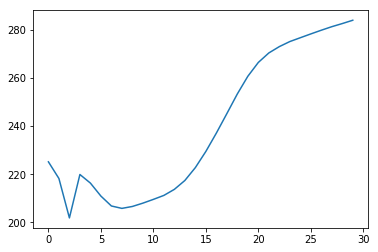

In [38]:
plt.plot(mean['TAP'][-nlev:, 0, 0])

## Load an Aquaplanet file and process as input for NN

These files have been preprocessed with the matlab script to compute derived variables

In [39]:
#data_dir = '/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old/'
#aqua_fn = 'AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-05-00000.nc'
data_dir = '/Users/gentine/Dropbox/Collaborations_Projects/CONN/SP-CAM/Pritchard_Aquaplanet/'   # New file directly from Pierre!
aqua_fn = 'AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc'  # Just randomly grab a file

In [40]:
aqua = nc.Dataset(data_dir + aqua_fn)

In [41]:
aqua

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    source: CAM
    case: AndKua_aqua_SPCAM3.0
    title: 
    logname: tg802402
    host: 
    Version: $Name:  $
    revision_Id: $Id: history.F90,v 1.26.2.38 2003/12/15 18:52:35 hender Exp $
    history: Tue Feb  6 09:26:27 2018: /anaconda3/bin/ncks -x -v TPHYSTND_NORAD --overwrite --output=./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc ./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc
Tue Feb  6 09:26:26 2018: /anaconda3/bin/ncks -x -v QBP --overwrite --output=./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc ./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc
Tue Feb  6 09:26:24 2018: /anaconda3/bin/ncks -x -v TBP --overwrite --output=./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc ./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.n

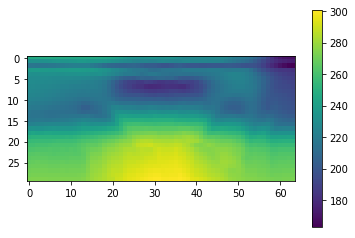

In [42]:
# Let's plot one input and one output variable
plt.imshow(aqua['TAP'][-1, :, :, 0]);
plt.colorbar();

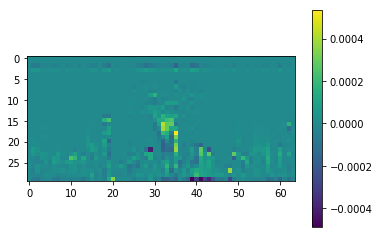

In [43]:
plt.imshow(aqua['SPDT'][-1, :, :, 0]);
plt.colorbar();

Now define the input and output variables. They need to be in the right order!

In [44]:
# TBP,QBP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic
#inps = ['TBP','QBP','PS','SHFLX','LHFLX','dTdt_adiabatic','dQdt_adiabatic']
inps = ['TAP','QAP','PS','SHFLX','LHFLX','dTdt_adiabatic','dQdt_adiabatic']

In [45]:
outps = ['SPDT','SPDQ']

The following script takes each variable, normalizes it by subtracting the mean and dividing by the standard deviation. Then the 2D variables (PS) are tiled to fill the 30 levels. We do this for the input and output array.

Note that additionally the vertical axis is flipped.

In [46]:
folderPath = '../SP-CAM/Pritchard_Aquaplanet/'
rawFileBase= 'AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-01-00001.nc'
config = load_config(model_dir, subset=None)
print(config)
a = DataLoader(folderPath, config, rawFileBase)

[read] PARAM path: ./logs/0217_120904_SPDT,SPDQ_layers_1024,1024_lr_0.00025_ac_leakyrelu_conv_False_locconv_False_vars_TAP,QAP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic_batchs_1024_loss_RMSE/params.json
Namespace(act='leakyrelu', addon='', batch_size=1024, beta1=0.5, beta2=0.999, convert_units=False, convo=False, data_dir='data', data_format='NCHW', data_path='data/SPDT,SPDQ', epoch=200, filter_size=3, frac_train=0.8, gamma=0.5, hidden='1024,1024', input_names='TAP,QAP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic', is_train=True, keep_dropout_rate=1.0, lambda_k=0.001, load_path='', local=False, localConvo=False, log_dir='logs', log_level='INFO', log_step=50, lossfct='RMSE', lr=0.00025, lr_lower_boundary=2e-08, lr_update_epoch=1, lr_update_step=5000, max_step=1000000, model_dir='logs/0217_120904_SPDT,SPDQ_layers_1024,1024_lr_0.00025_ac_leakyrelu_conv_False_locconv_False_vars_TAP,QAP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic_batchs_1024_loss_RMSE', model_name='0217_120904_SPDT,SPDQ

In [47]:
#fileReader = folderPath + rawFileBase
#print(fileReader)
#print(config.input_names.split(","))
iTim = 1
#inX = a.prepareData(aqua, iTim, doLog=True)
X = a.accessTimeData(aqua, config.input_names.split(","), iTim, doLog=True)
#print(inX)
X.shape
X=np.asarray(X)
# now change dimensions (7, 30, 64, 128) -> (8192, 7, 30, 1)
print(X.shape[:2])
#print(X.shape[:2]+[-1])
shapes = X.shape
print(shapes)
n_lev = shapes[1]
print(n_lev)
print(shapes)
#X = tf.reshape(X, [X.shape[:2],-1])# first flatten last domension
X = np.reshape(X, (shapes[0],shapes[1],-1))# first flatten last domension
X.shape
X = np.transpose(X, [2,0,1]) # now cahnge axes
X.shape
X = np.expand_dims(X, -1)
X.shape
X = X[:,:,-n_lev:,:][:,:,::-1]
X.shape

accessTimeData varDim[k]= 4 fileReader[k]= (48, 30, 64, 128)
TAP ----> arr= (30, 64, 128)
TAP --------> arr= (30, 64, 128)
TAP ------------> arr= (30, 64, 128)
accessTimeData varDim[k]= 4 fileReader[k]= (48, 30, 64, 128)
QAP ----> arr= (30, 64, 128)
QAP --------> arr= (30, 64, 128)
QAP ------------> arr= (30, 64, 128)
accessTimeData varDim[k]= 3 fileReader[k]= (48, 64, 128)
PS ----> arr= (1, 64, 128)
PS --------> arr= (1, 64, 128)
PS ------------> arr= (30, 64, 128)
accessTimeData varDim[k]= 3 fileReader[k]= (48, 64, 128)
SHFLX ----> arr= (1, 64, 128)
SHFLX --------> arr= (1, 64, 128)
SHFLX ------------> arr= (30, 64, 128)
accessTimeData varDim[k]= 3 fileReader[k]= (48, 64, 128)
LHFLX ----> arr= (1, 64, 128)
LHFLX --------> arr= (1, 64, 128)
LHFLX ------------> arr= (30, 64, 128)
accessTimeData varDim[k]= 4 fileReader[k]= (48, 30, 64, 128)
dTdt_adiabatic ----> arr= (30, 64, 128)
dTdt_adiabatic --------> arr= (30, 64, 128)
dTdt_adiabatic ------------> arr= (30, 64, 128)
accessTimeData v

(8192, 7, 30, 1)

In [50]:
print(model)
preds = model.predict(X)
print(preds.shape)
preds = np.reshape(preds, (shapes[2],shapes[3],-1,n_lev))# reshape
print(preds.shape)

(8192, 2, 30, 1)
(64, 128, 2, 30)


(64, 30)
[-34758.285 -34721.656 -34690.137 -34678.03  -34662.695 -34671.113
 -34662.043 -34622.395 -34567.582 -34513.453 -34443.477 -34336.125
 -34196.7   -34012.418 -33804.957 -33750.965 -33793.145 -33830.9
 -33944.12  -34079.78  -34242.254 -34351.04  -34406.137 -34436.33
 -34476.8   -34503.438 -34484.926 -34456.105 -34409.29  -34385.203
 -34351.03  -34369.13  -34347.27  -34309.195 -34307.438 -34346.1
 -34406.02  -34475.805 -34515.05  -34600.266 -34686.594 -34761.773
 -34828.434 -34828.844 -34721.25  -34548.277 -34392.96  -34227.324
 -34034.82  -33804.043 -33542.47  -33275.68  -32985.582 -32724.975
 -32636.156 -32720.596 -32826.418 -32842.113 -32775.97  -32753.123
 -32773.47  -32816.97  -32916.523 -33025.094]


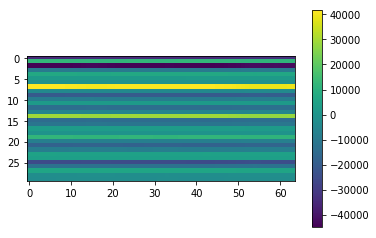

In [51]:
toshow = preds[:,0,0,-nlev:]
print(toshow.shape)
plt.imshow(np.transpose(toshow,(1,0))); # Vertical axis is flipped.
plt.colorbar();
print(preds[:,0,0,0])

(30,)
(30,)
(64, 30)


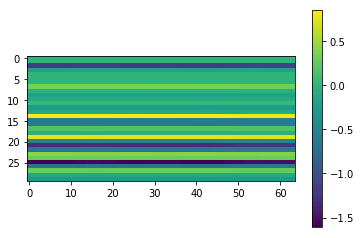

In [52]:
mean_SPDT = mean['SPDT'][-nlev:, 0, 0]
std_SPDT = std['SPDT'][-nlev:, 0, 0]
print(mean_SPDT.shape)
print(std_SPDT.shape)
toshow = preds[:,0,0,-nlev:]*std_SPDT+mean_SPDT
print(toshow.shape)
plt.imshow(np.transpose(toshow,(1,0))); # Vertical axis is flipped.
plt.colorbar();

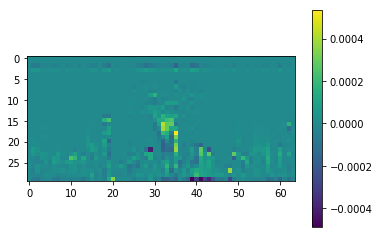

In [132]:
# snif snouf
# waht we were expecting
plt.imshow(aqua['SPDT'][-1, :, :, 0]);
plt.colorbar();

## Get model predictions

We will now use the normalized input array and check out the predictions

In [28]:
inp_arr.shape

NameError: name 'inp_arr' is not defined

In [28]:
preds = model.predict(inp_arr, batch_size=1024)

NameError: name 'inp_arr' is not defined

In [206]:
preds.shape, outp_arr.shape

((393216, 2, 30, 1), (393216, 2, 30, 1))

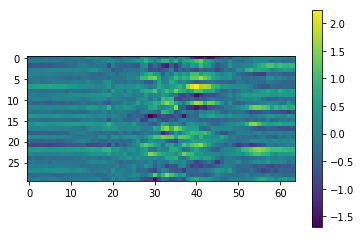

In [207]:
# First, check the raw predictions which should match the normalized outputs
plt.imshow(unravel(preds)[-1, :, 0, 0, :].T); # Vertical axis is flipped.
plt.colorbar();

In [208]:
def denorm(arr, vars):
    # Inputs [sample, feature, lev, 1]
    a = np.copy(arr)
    a = a.reshape(48, 64, 128, -1, nlev)  # [time, lat, lon, feature, lev]
    for i, var in enumerate(vars):
        m = np.rollaxis(mean[var][-nlev:][::-1], 0, 3) 
        s = np.rollaxis(std[var][-nlev:][::-1], 0, 3) 
        a[:, :, :, i, :] = a[:, :, :, i, :] * s + m
    return a

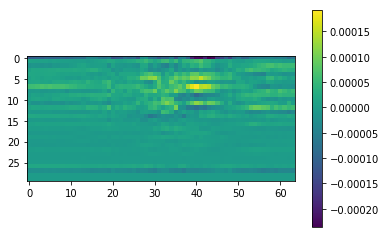

In [209]:
# Try to denormalize the predictions
plt.imshow(denorm(unravel(preds), outps)[-1, :, 0, 0, :].T); # Vertical axis is flipped.
plt.colorbar();

In [210]:
ilat=30; ilon=20

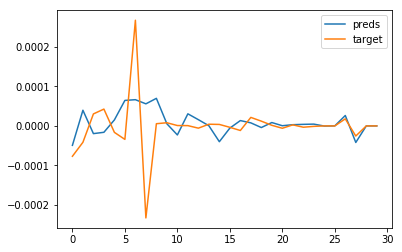

In [211]:
plt.plot(denorm(unravel(preds), outps)[-1, ilat, ilon, 0, :], label='preds')
plt.plot(denorm(unravel(outp_arr), outps)[-1, ilat, ilon, 0, :], label='target')
plt.legend();

So something is off here. Maybe I messed up the input processing. The order of the input variables could be wrong...

## Old stuff

In [69]:
def unravel(x, nlev=30):
    return x.reshape(48, 64, 128, -1, nlev)

In [21]:
preds_de = denorm(preds, outps); preds_de.shape

(48, 64, 128, 2, 30)

In [22]:
out_de = denorm(outp_arr, outps)

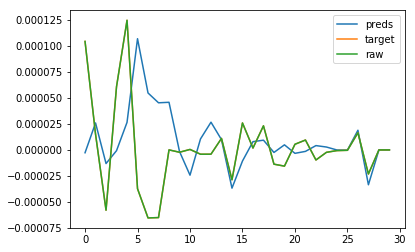

In [63]:
plt.plot(preds_de[4, 30, 60, 0, :], label='preds')
plt.plot(out_de[4, 30, 60, 0, :], label='target')
plt.plot(aqua['TPHYSTND_NORAD'][4, ::-1, 30, 60], label='raw')
plt.legend();

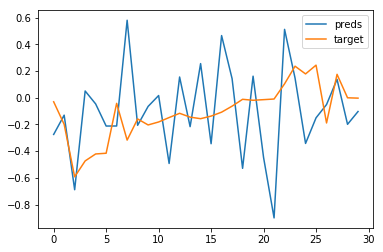

In [68]:
plt.plot(preds[0, 0, :, 0], label='preds')
plt.plot(outp_arr[0, 0, :, 0], label='target')
plt.legend();

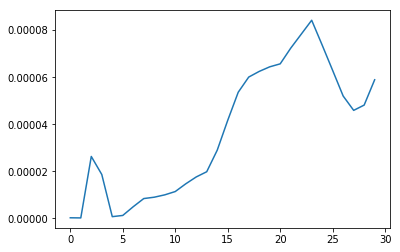

In [77]:
plt.plot(std['TPHYSTND_NORAD'][:, 0, 0])

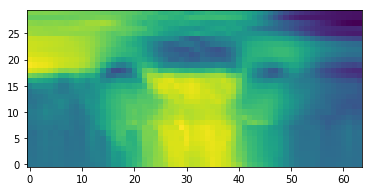

In [83]:
plt.imshow(
    unravel(inp_arr)[-1, :, 38, 0, :].T,
    origin='lower')

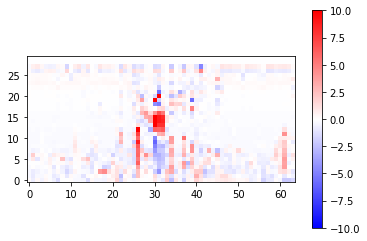

In [84]:
plt.imshow(
    unravel(outp_arr)[-1, :, 38, 0, :].T, 
    origin='lower', cmap='bwr', vmin=-10, vmax=10)
plt.colorbar()

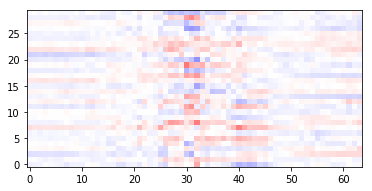

In [85]:
plt.imshow(
    unravel(preds)[-1, :, 38, 0, :].T, 
    origin='lower', cmap='bwr', vmin=-5, vmax=5)

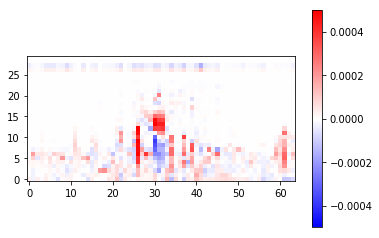

In [86]:
plt.imshow(out_de[-1, :, 38, 0, :].T, origin='lower', cmap='bwr', vmin=-5e-4, vmax=5e-4)
plt.colorbar()

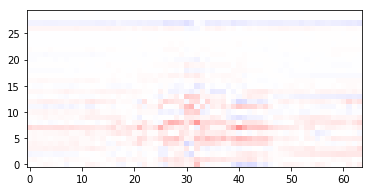

In [87]:
plt.imshow(preds_de[-1, :, 38, 0, :].T, origin='lower', cmap='bwr', vmin=-5e-4, vmax=5e-4)

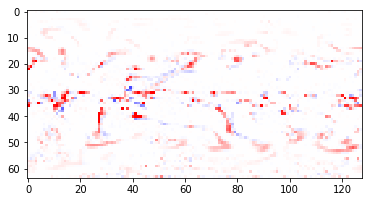

In [88]:
plt.imshow(out_de[-1, :, :, 0, 10], cmap='bwr', vmin=-5e-4, vmax=5e-4)

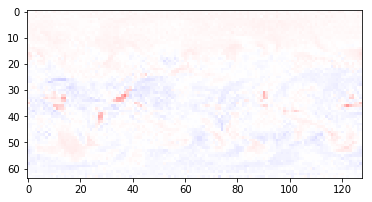

In [89]:
plt.imshow(preds_de[-1, :, :, 0, 10], cmap='bwr', vmin=-5e-4, vmax=5e-4)